In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

import math
import time

import skrf
from skrf import Network

import utils
import os

from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# Grab some data

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 23

In [4]:
test_net = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)['network']

In [5]:
print("S-parameters shape: ", test_net.s.shape)
print("S-parameters type: ", test_net.s.dtype)

S-parameters shape:  (2081, 2, 2)
S-parameters type:  complex128


In [6]:
N_PORTS = test_net.nports
N_FREQS = test_net.frequency.npoints

print("N_FREQS: ", N_FREQS)
print("N_PORTS: ", N_PORTS)

N_FREQS:  2081
N_PORTS:  2


In [7]:
reciprocity = skrf.network.reciprocity(test_net.s)

EPS_SMALL = 1e-6

IS_RECIPROCAL = False
if np.sum(np.abs(reciprocity)) < EPS_SMALL:
    IS_RECIPROCAL = True
    
print("RECIPROCAL: ", IS_RECIPROCAL)

RECIPROCAL:  True


# Look at the HLAS results 

In [8]:
case_str = "case" + (str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM))
case_fname = os.path.join(ROOT_PATH, case_str)

print(case_fname)

/scratch1/04703/sravula/UTAFSDataNew/new_data/case23


In [9]:
children = os.listdir(case_fname)

time_fpth = [f for f in children if "TIME" in f][0]
time_fpth = os.path.join(case_fname, time_fpth)

HLAS_fpth = [f for f in children if "HLAS.s" in f][0]
HLAS_fpth = os.path.join(case_fname, HLAS_fpth)

HLAS_meas_fpth = [f for f in children if "SIMULATIONS" in f][0]
HLAS_meas_fpth = os.path.join(case_fname, HLAS_meas_fpth)

print(time_fpth)
print(HLAS_fpth)
print(HLAS_meas_fpth)

/scratch1/04703/sravula/UTAFSDataNew/new_data/case23/SIEMENS_AFS_TIME_IN_SECONDS.txt
/scratch1/04703/sravula/UTAFSDataNew/new_data/case23/case23.HLAS.s2p
/scratch1/04703/sravula/UTAFSDataNew/new_data/case23/SIEMENS_AFS_SAMPLE_POINT_SIMULATIONS.s2p


In [10]:
HLAS_net = Network(HLAS_fpth)
HLAS_meas_net = Network(HLAS_meas_fpth)

with open(time_fpth) as file:
    lines = [line.rstrip() for line in file]
HLAS_time = lines[0]

In [11]:
print("HLAS time: ", HLAS_time)

HLAS time:  12.138435125350952


In [12]:
print("HLAS shape: ", HLAS_net.s.shape)
print("HLAS meas shape: ", HLAS_meas_net.s.shape)

HLAS shape:  (2081, 2, 2)
HLAS meas shape:  (155, 2, 2)


In [13]:
M_HLAS = HLAS_meas_net.s.shape[0]
print(M_HLAS)

155


In [14]:
test_net_twochan = np.stack((test_net.s.real, test_net.s.imag), axis=-1)
HLAS_net_twochan = np.stack((HLAS_net.s.real, HLAS_net.s.imag), axis=-1)

print(test_net_twochan.shape)
print(test_net_twochan.dtype)

print(HLAS_net_twochan.shape)
print(HLAS_net_twochan.dtype)

(2081, 2, 2, 2)
float64
(2081, 2, 2, 2)
float64


In [15]:
HLAS_psnr = psnr(test_net_twochan, HLAS_net_twochan)
print("HLAS PSNR: ", HLAS_psnr)

HLAS PSNR:  42.298234016428175


# Grab a toch tensor from this guy

In [16]:
x_test = utils.network_to_sparams(test_net)
print(x_test.shape)
print(x_test.dtype)

torch.Size([1, 6, 2081])
torch.float32


In [17]:
x_HLAS = utils.network_to_sparams(HLAS_net)
print(x_HLAS.shape)
print(x_HLAS.dtype)

torch.Size([1, 6, 2081])
torch.float32


# Grab the measurements that we will use as our ground truth

In [18]:
MEASUREMENT_SPACING = "equal"
M_GT = M_HLAS #0.1 #The ratio of measurements in our gold standard

KEPT_INDS_GT, MISSING_INDS_GT = utils.get_inds(MEASUREMENT_SPACING, N_FREQS, M_GT)

M_GT = len(KEPT_INDS_GT)

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M_GT)
print("Undersampling Ratio: ", M_GT/N_FREQS)

Number of Ground Truth Frequency Points:  2081
Number of Measurements:  155
Undersampling Ratio:  0.07448342143200384


In [19]:
y_test = torch.clone(x_test)[:, :, KEPT_INDS_GT]

print("y_test shape: ", y_test.shape)

y_test shape:  torch.Size([1, 6, 155])


In [20]:
z_test = torch.clone(x_test)
z_test[:, :, MISSING_INDS_GT] = 0

print("z_test shape: ", z_test.shape)

z_test shape:  torch.Size([1, 6, 2081])


# Check if we need to interpolate the measurements for pre-training

In [21]:
meas_net = test_net[KEPT_INDS_GT]

print(meas_net.s.shape)

(155, 2, 2)


In [22]:
MIN_MEAS_LEN = int(0.1 * N_FREQS) #minimum number of measurements for pre-training

if M_GT < MIN_MEAS_LEN:
    print("Interpolating measurements for pre-training")
    scale_fac = int(np.ceil(MIN_MEAS_LEN / M_GT))
    new_len = scale_fac * (M_GT - 1) + 1
    meas_net.resample(new_len)
    y_pretrain = utils.network_to_sparams(meas_net)
else:
    y_pretrain = y_test.clone()

print(y_pretrain.shape)
print(y_pretrain.dtype)

Interpolating measurements for pre-training
torch.Size([1, 6, 309])
torch.float32


# Plot the Data and measurements 

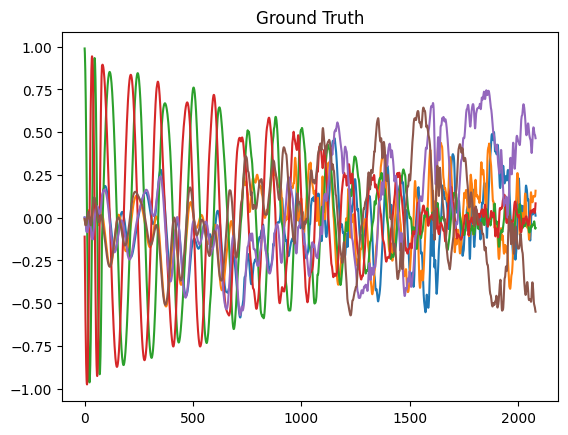

In [23]:
plt.figure()
for i in range(x_test.shape[1]//2):
    plt.plot(x_test[0, 2*i], label=str(i)+" Re")
    plt.plot(x_test[0, 2*i+1], label=str(i)+" Im")
plt.title("Ground Truth")
plt.show()

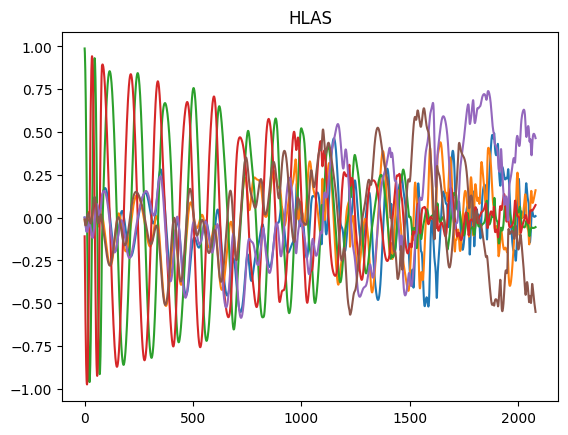

In [24]:
plt.figure()
for i in range(x_HLAS.shape[1]//2):
    plt.plot(x_HLAS[0, 2*i], label=str(i)+" Re")
    plt.plot(x_HLAS[0, 2*i+1], label=str(i)+" Im")
plt.title("HLAS")
plt.show()

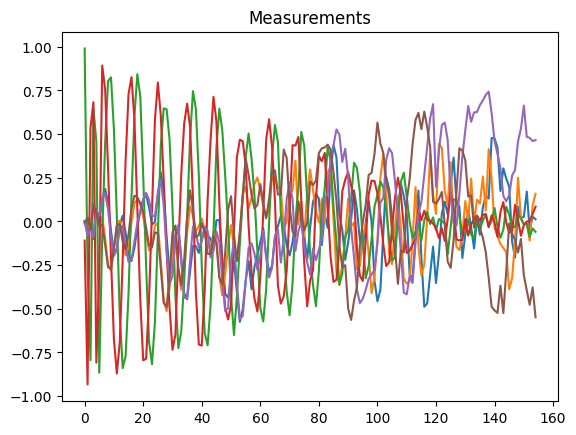

In [25]:
plt.figure()
for i in range(y_test.shape[1]//2):
    plt.plot(y_test[0, 2*i], label=str(i)+" Re")
    plt.plot(y_test[0, 2*i+1], label=str(i)+" Im")
plt.title("Measurements")
plt.show()

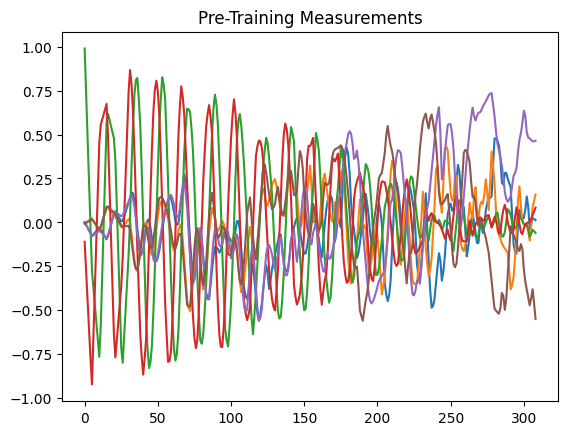

In [26]:
plt.figure()
for i in range(y_pretrain.shape[1]//2):
    plt.plot(y_pretrain[0, 2*i], label=str(i)+" Re")
    plt.plot(y_pretrain[0, 2*i+1], label=str(i)+" Im")
plt.title("Pre-Training Measurements")
plt.show()

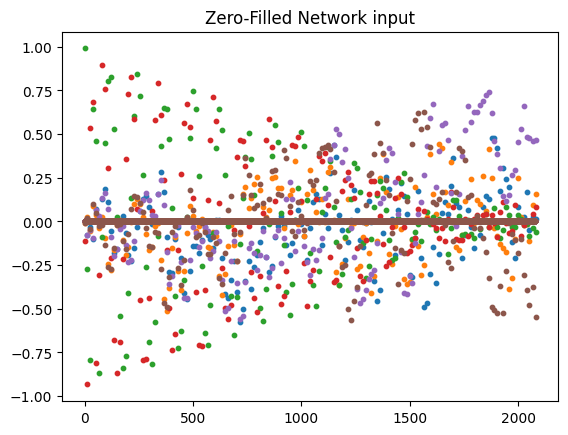

In [27]:
plt.figure()
for i in range(z_test.shape[1]//2):
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i], label=str(i)+" Re", s=10)
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i+1], label=str(i)+" Im", s=10)
plt.title("Zero-Filled Network input")
plt.show()

# Decide the Pre-Training Parameters

In [28]:
NUM_SCALES = 1
FATHER_SCALES = [1/i for i in range(1, NUM_SCALES+1)][::-1]

print("FATHER_SCALES: ", FATHER_SCALES)

FATHER_SCALES:  [1.0]


In [29]:
FATHER_SAMPLES = []

for M in FATHER_SCALES:
    if M == 1.0:
        FATHER_SAMPLES.append(y_pretrain)
    else:    
        KEPT_INDS, _ = utils.get_inds(MEASUREMENT_SPACING, y_pretrain.shape[-1], M)
        FATHER_SAMPLES.append(torch.clone(y_pretrain)[:, :, KEPT_INDS])

torch.Size([1, 6, 309])


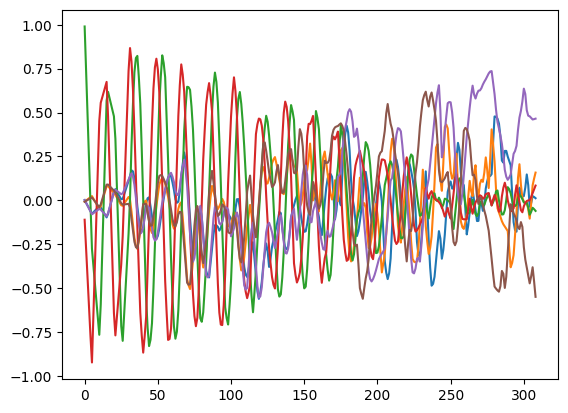

In [30]:
for FATHER in FATHER_SAMPLES:
    print(FATHER.shape)
    
    plt.figure()
    for i in range(FATHER.shape[1]//2):
        plt.plot(FATHER[0, 2*i], label=str(i)+" Re")
        plt.plot(FATHER[0, 2*i+1], label=str(i)+" Im")
    plt.show()

# Define the Augmentations

In [31]:
class Permute_Channels(object):
    """
    Augmentation that takes in a [2*Sparam, N_FREQ] array and returns a version with the S-parameters
        permuted randomly, making sure that pairs of adjacent real/imaginary channels stay together.
    """
    def __init__(self):
        pass
    
    def __call__(self, x):
        n_params = x.shape[-2] // 2 #number of s-parameters
        
        permuted_params = np.random.permutation(n_params) #randomly shuffled list [0...n_params]
        permuted_params = np.repeat(permuted_params, (2)) #repeat each permuted index e.g. [0,2,1]->[0,0,2,2,1,1]
        permuted_params[::2] = permuted_params[::2]*2 #double the even indices
        permuted_params[1::2] = permuted_params[1::2]*2 + 1 #double and offset the odd indices
        
        return x[permuted_params, :] #return a copy of the input with its channels permuted in pairs of re/im

In [32]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class FatherDataset(Dataset):
    def __init__(self, father_samples, noise_sigma=0.01, measurement_spacing="equal", transform=None):
        self.father_samples = [father.clone().squeeze(0) for father in father_samples]
        self.noise_sigma = noise_sigma
        self.measurement_spacing = measurement_spacing
        self.transform = transform
    
    def __len__(self):
        return len(self.father_samples)
    
    def __getitem__(self, idx):
        #(1) grab the proper tensor
        x = self.father_samples[idx]
        if self.transform:
            x = self.transform(x)
        
        len_x = x.shape[-1]
        
        #(2) grab the appropriate measurements from the father
        m = random.uniform(0.01, 0.2) #randomly sample the undersampling factor, with min 2 and max 50% samples
        kept_inds, missing_inds = utils.get_inds(self.measurement_spacing, len_x, m)

        z = torch.clone(x)
        z[:, missing_inds] = 0
        if self.noise_sigma:
            z = z + self.noise_sigma*torch.randn_like(z)
        
        return x, z

# Test a weighted selection of fathers

In [33]:
selection_prob = [np.exp(-1/i) for i in FATHER_SCALES]
sampler = WeightedRandomSampler(selection_prob, 1000, replacement=True)

print(selection_prob)

[0.36787944117144233]


In [34]:
transform = Permute_Channels()

dataset = FatherDataset(FATHER_SAMPLES, transform = transform)

dataloader = DataLoader(dataset, batch_size=1, sampler=sampler)

In [35]:
lens = {}

for x, _ in dataloader:
    len_x = x.shape[-1]
    if len_x in list(lens.keys()):
        lens[len_x] += 1
    else:
        lens[len_x] = 1

In [36]:
keys = sorted(lens.keys())
for k in keys:
    print(str(k) + ": " + str(lens[k]))

309: 1000


# Make the network

In [37]:
NC = NZ = y_pretrain.shape[-2]

MIN_LEN = FATHER_SAMPLES[0].shape[-1]
NUM_LAYERS = int(np.ceil(np.log2(MIN_LEN))) - 1
    
BASE_NGF = int(30 * np.sqrt(NZ))
    
KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

K = 1 #interpolation factor
NEW_CAUSAL = True

In [38]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("MIN LEN: ", str(MIN_LEN))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  6
NUM_LAYERS:  8
MIN LEN:  309
BASE NGF:  73
NC:  6
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  False
K:  1
NEW_CAUSAL True


In [39]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE,
                       k=K,
                       new_causality=NEW_CAUSAL)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [40]:
z_temp = torch.randn((1, NZ, MIN_LEN)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 309])


In [41]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  802032


# Define Training Params and Run

In [42]:
LR = 2e-4

BASE_ITERS = 500
NUM_ITERS_PER_RES = [BASE_ITERS*(3**i) for i in range(NUM_SCALES)]

CUR_FATHERS = []

criterion = nn.MSELoss(reduction="mean")
criterion = criterion.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

loss_list = []

In [43]:
transform = None #Permute_Channels()
noise_sigma = 0.01

In [44]:
pbar = tqdm(total=np.sum(NUM_ITERS_PER_RES))

for i in range(NUM_SCALES):
    CUR_FATHERS.append(FATHER_SAMPLES[i])

    selection_prob = [np.exp(-1/l) for l in FATHER_SCALES[0:i+1]]
    sampler = WeightedRandomSampler(selection_prob, NUM_ITERS_PER_RES[i], replacement=True)

    dataset = FatherDataset(CUR_FATHERS, transform = transform, noise_sigma=noise_sigma)
    dataloader = DataLoader(dataset, batch_size=1, sampler=sampler)

    print("SCALE IDX: ", i)
    print("NUM ITERS FOR CURRENT SCALE: ", NUM_ITERS_PER_RES[i])
    print("SELECTION PROB: ", selection_prob)
    
    for j, (x, z) in enumerate(dataloader):
        optim.zero_grad()
        
        x = x.to(device)
        z = z.to(device)
        
        out = net.forward(z)
        
        train_loss = criterion(out, x)
        
        train_loss.backward()
        optim.step()
        
        #log
        train_loss = train_loss.item()
        loss_list.append(train_loss)
        
        pbar.update(1)

pbar.close()

  0%|          | 0/500 [00:00<?, ?it/s]

SCALE IDX:  0
NUM ITERS FOR CURRENT SCALE:  500
SELECTION PROB:  [0.36787944117144233]


100%|██████████| 500/500 [00:14<00:00, 33.59it/s]


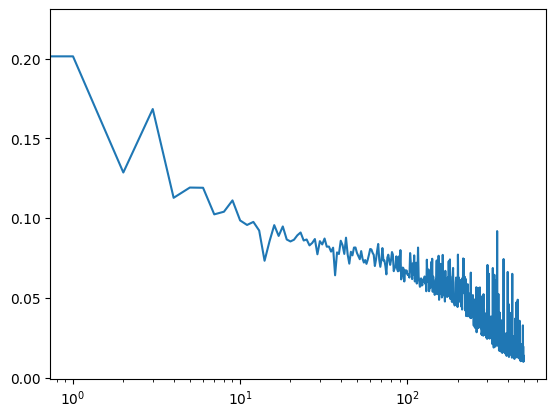

In [45]:
plt.figure()
plt.plot(loss_list)
plt.xscale("log")
plt.show()

# Now try on the actual test data

In [46]:
z_test = z_test.to(device)

out = net.forward(z_test)

In [47]:
x_test = x_test.cpu().detach().numpy()
out = out.cpu().detach().numpy()
z_test = z_test.cpu().detach().numpy()

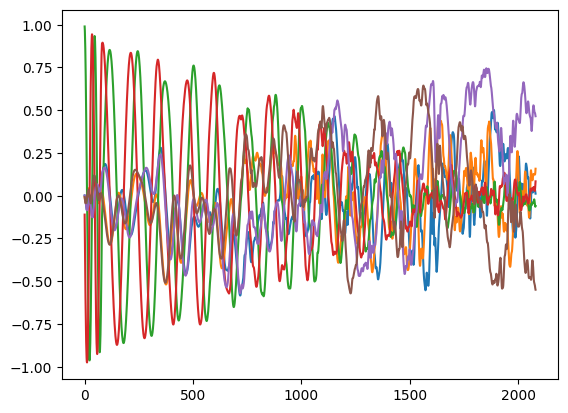

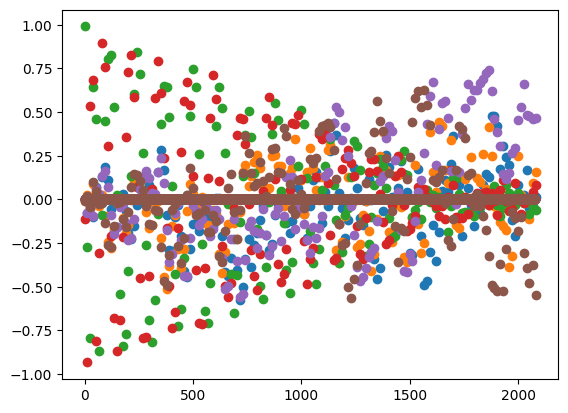

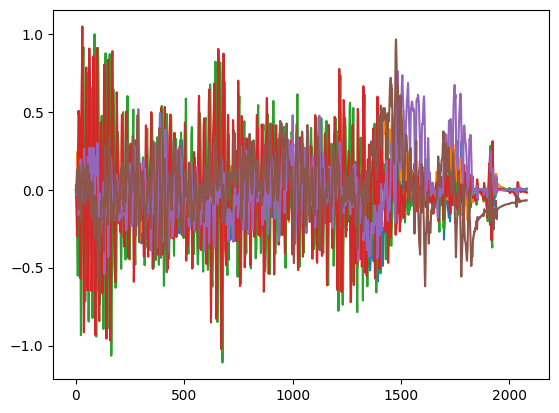

In [48]:
plt.figure()
for i in range(x_test.shape[1]//2):
    plt.plot(x_test[0, 2*i])
    plt.plot(x_test[0, 2*i+1])
plt.show()

plt.figure()
for i in range(z_test.shape[1]//2):
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i])
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i+1])
plt.show()

plt.figure()
for i in range(out.shape[1]//2):
    plt.plot(out[0, 2*i])
    plt.plot(out[0, 2*i+1])
plt.show()

# Now let's do DIP

In [49]:
LR = 2e-4 
NUM_ITER = 5000 

REG_HYPERPARAM = 0.1 #1.0
REG_TYPE = "smoothing"
REG_TARGET = None #this is only sety if we are using centered_wd regularisation
REG_ORDER = 3
REG_NORM = 1

REDUCTION = "mean"

In [50]:
START_NOISE_LEVEL = 0.01
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

Noise decay factor:  0.9995395890030878


In [51]:
SGLD = True
BURN_IN_ITER = 0
SAVE_OUTPUT_EVERY = NUM_ITER//50

In [52]:
y_test = y_test.to(device)
x_test = torch.from_numpy(x_test).to(device)
z_test = torch.from_numpy(z_test).to(device)

In [53]:
import Fitting

dip_args = {"y": y_test,
            "x": x_test,
            "z": z_test,
            "device": device,
            "model": net,
            "lr": LR,
            "num_iter": NUM_ITER,
            "reg_type": REG_TYPE,
            "reg_lambda": REG_HYPERPARAM,
            "reg_target": REG_TARGET,
            "reg_order": REG_ORDER,
            "reg_norm": REG_NORM,
            "reduction": REDUCTION,
            "kept_inds": KEPT_INDS_GT,
            "input_noise_start": START_NOISE_LEVEL,
            "input_noise_decay": NOISE_DECAY_FACTOR,
            "perturb_weights": SGLD,
            "burn_in_iter": BURN_IN_ITER,
            "save_output_every": SAVE_OUTPUT_EVERY,
            "debug": True}
dip_args = Fitting.dict2namespace(dip_args)

In [54]:
dip_results = Fitting.run_dip(dip_args)

  0%|          | 0/5000 [00:00<?, ?it/s]

# 3. Visualize and get metrics

In [55]:
print(dip_results.__dict__.keys())

dict_keys(['out_list', 'mse_list_gt', 'mse_list_meas', 'mse_list_mean_gt', 'mse_list_mean_meas', 'reg_list'])


In [56]:
print("Final MSE: %.2e" % dip_results.mse_list_gt[-1])
print("Final Mean MSE: %.2e" % dip_results.mse_list_mean_gt[-1])

Final MSE: 5.12e-04
Final Mean MSE: 8.96e-04


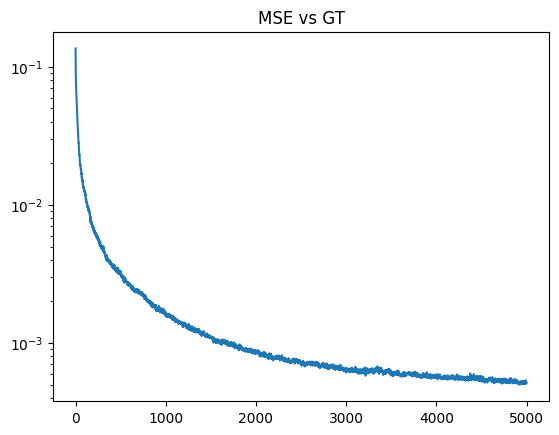

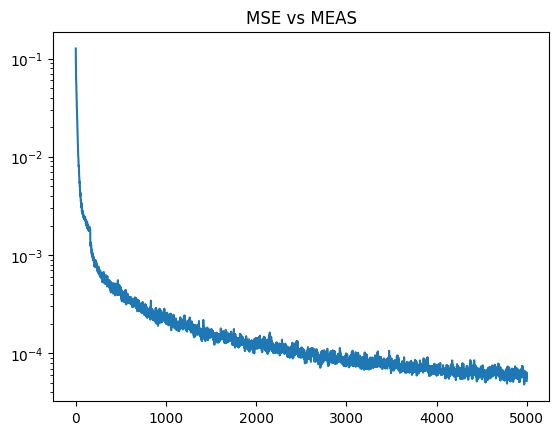

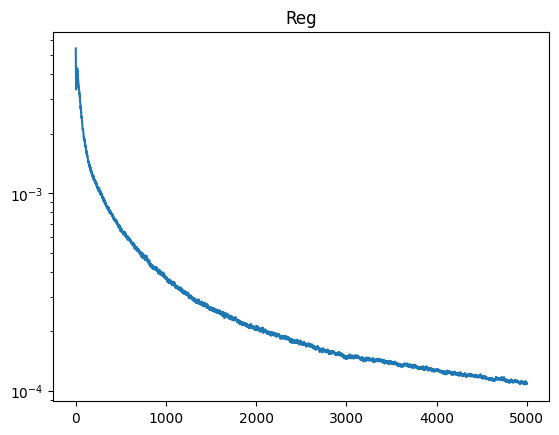

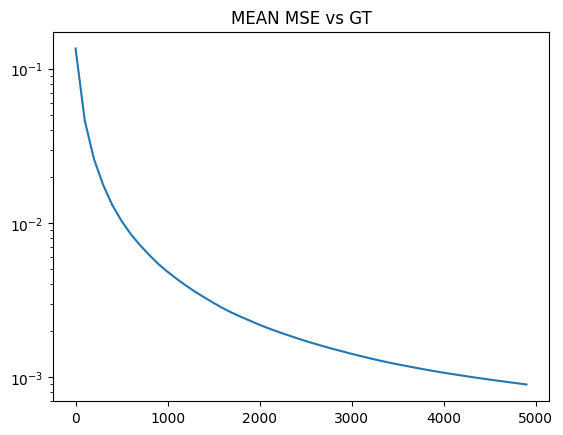

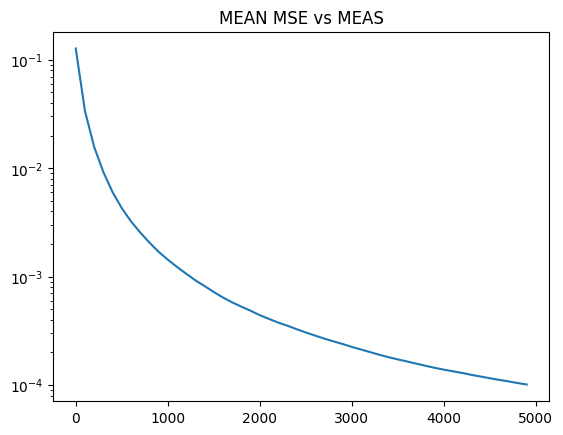

In [57]:
MAX_IDX = 100

plt.figure()
plt.plot(dip_results.mse_list_gt)
plt.title("MSE vs GT")
# plt.ylim(0, dip_results.mse_list_gt[MAX_IDX])
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(dip_results.mse_list_meas)
plt.title("MSE vs MEAS")
# plt.ylim(0, dip_results.mse_list_meas[MAX_IDX])
plt.yscale("log")
plt.show()

if hasattr(dip_results, "reg_list"):
    plt.figure()
    plt.plot(dip_results.reg_list)
    plt.title("Reg")
    # plt.ylim(0, dip_results.reg_list[MAX_IDX])
    plt.yscale("log")
    plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_gt)
plt.title("MEAN MSE vs GT")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_meas)
plt.title("MEAN MSE vs MEAS")
plt.yscale("log")
plt.show()

In [58]:
mean_out = torch.mean(torch.cat(dip_results.out_list), dim=0, keepdim=True)
std_out = torch.std(torch.cat(dip_results.out_list), dim=0, keepdim=True)

In [59]:
last_out = dip_results.out_list[-1]

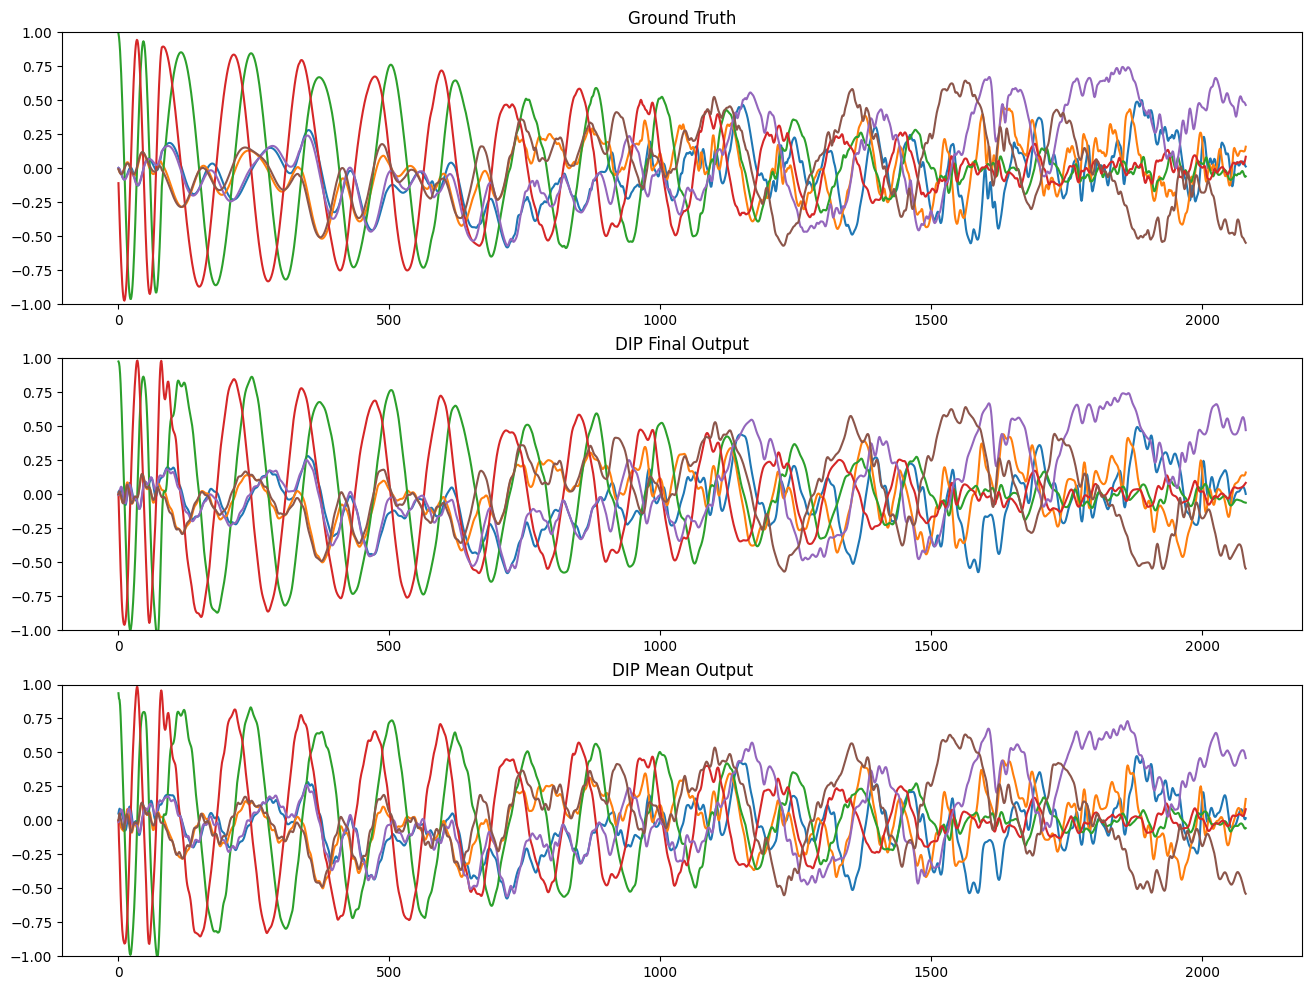

In [60]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_test.shape[1]):
    axes[0].plot(x_test[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)

for i in range(x_test.shape[1]):
    axes[1].plot(last_out[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Final Output")
axes[1].set_ylim(-1,1)

for i in range(x_test.shape[1]):
    axes[2].plot(mean_out[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Mean Output")
axes[2].set_ylim(-1,1)

plt.show()

Text(0.5, 1.0, 'Mean')

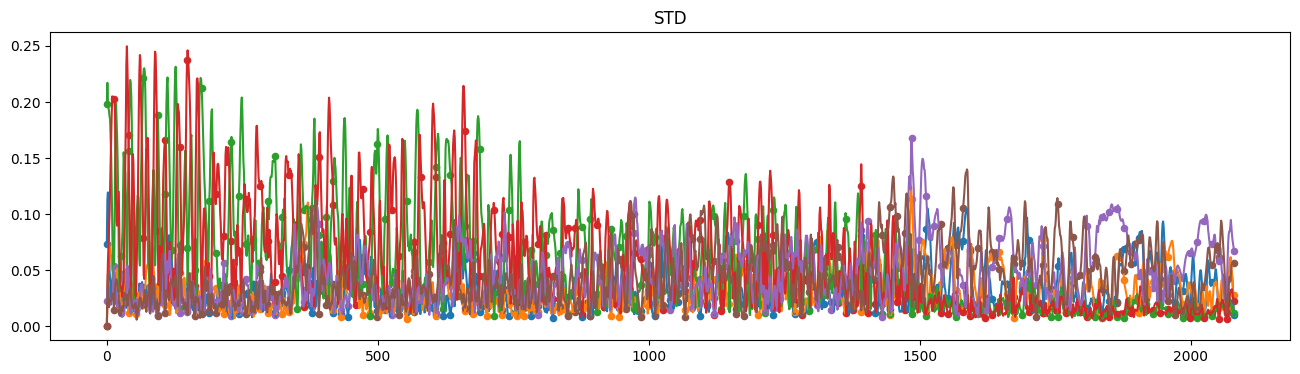

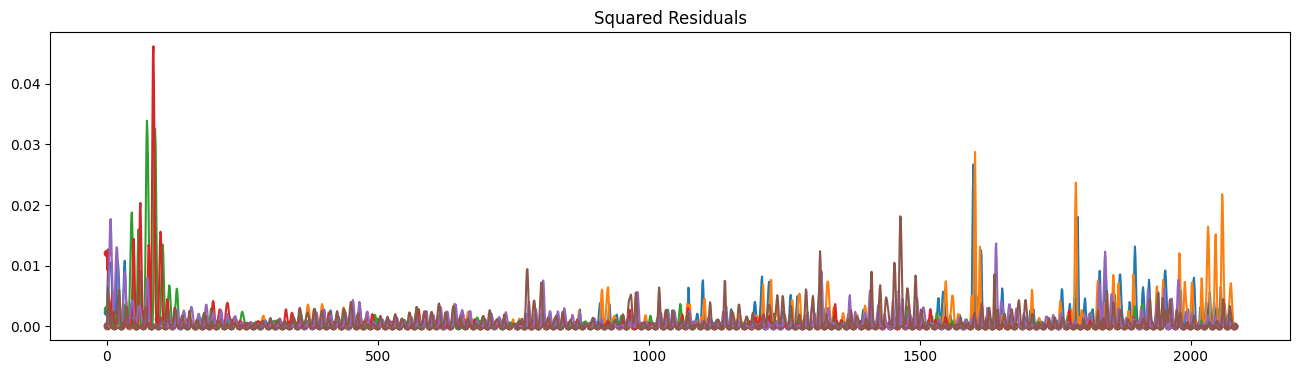

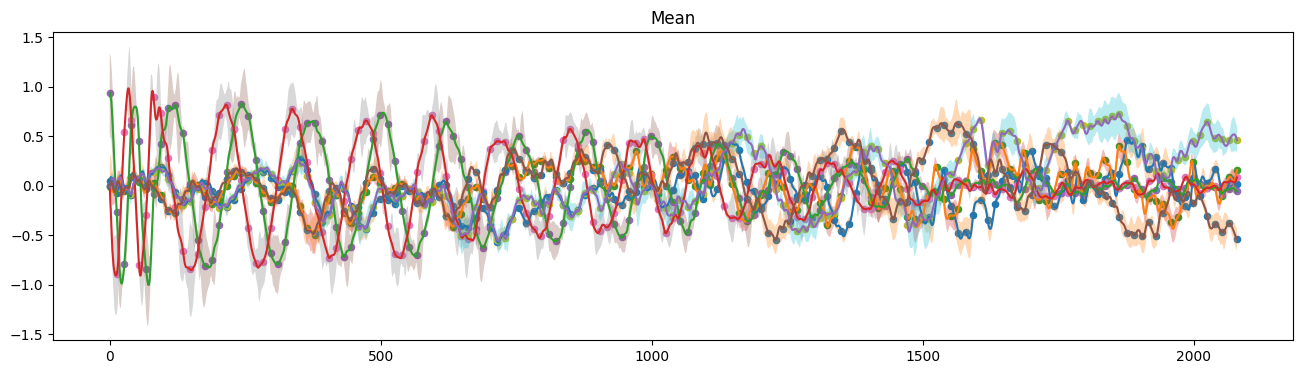

In [61]:
under_line = mean_out - 1.96*std_out
over_line = mean_out + 1.96*std_out

resid = torch.square(x_test - mean_out)

plt.figure(figsize=(16,4))
for i in range(std_out.shape[1]):
    plt.plot(std_out[0,i].detach().cpu(), label=str(i))
    plt.scatter(KEPT_INDS_GT, std_out[0,i][KEPT_INDS_GT].detach().cpu(), s=20)
plt.title("STD")

plt.figure(figsize=(16,4))
for i in range(resid.shape[1]):
    plt.plot(resid[0,i].detach().cpu(), label=str(i))
    plt.scatter(KEPT_INDS_GT, resid[0,i][KEPT_INDS_GT].detach().cpu(), s=20)
plt.title("Squared Residuals")

plt.figure(figsize=(16,4))
for i in range(mean_out.shape[1]):
    plt.plot(np.arange(N_FREQS), mean_out[0,i].detach().cpu(), label=str(i))
    plt.scatter(KEPT_INDS_GT, mean_out[0,i][KEPT_INDS_GT].detach().cpu(), s=20)
    plt.fill_between(np.arange(N_FREQS), under_line[0,i].detach().cpu(), over_line[0,i].detach().cpu(), alpha=0.3)
plt.title("Mean")

# Compute Metrics

In [62]:
#We need the output to be (N_FREQS, NPORTS, NPORTS, 2) real-valued
last_out_twochan = utils.sparams_to_matrix(last_out).detach().cpu().numpy().astype(np.float64)
mean_out_twochan = utils.sparams_to_matrix(mean_out).detach().cpu().numpy().astype(np.float64)

print(last_out_twochan.shape)
print(last_out_twochan.dtype)

print(mean_out_twochan.shape)
print(mean_out_twochan.dtype)

(2081, 2, 2, 2)
float64
(2081, 2, 2, 2)
float64


In [63]:
psnr_mean = psnr(test_net_twochan, mean_out_twochan)
psnr_last = psnr(test_net_twochan, last_out_twochan)

print("PSNR (MEAN): ", psnr_mean)
print("PSNR (LAST): ", psnr_last)

PSNR (MEAN):  36.747699185968074
PSNR (LAST):  39.05644666006719


In [64]:
print("PSNR (HLAS): ", HLAS_psnr)

PSNR (HLAS):  42.298234016428175
